## **[요구사항 1] titanic_dataset.py 분석**

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split


class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

**· 데이터 처리를 위해 Dataset 클래스를 상속받은 TitanicDataset 클래스를 선언함. 특징(X)과 타겟(y) 데이터를 각각 실수형 및 정수형 텐서로 변환하여 저장하고, 데이터셋의 길이(__len__), 특정 인덱스에 있는 데이터(__getitem__), 그리고 데이터셋의 기본 정보를 문자열로 출력하는 기능(__str__)이 있음.**

In [3]:
class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

**· TitanicTestDataset 클래스는 TitanicDataset과 유사한 기능을 하지만 오직 특징 데이터(X)만을 받으며, 타겟 레이블(y)이 없는 테스트 데이터를 처리하는 데 사용됨.**

In [4]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

**· 이 함수는 다음과 같은 과정으로 Titanic 데이터를 전처리하고, 이를 훈련, 검증, 테스트 데이터셋으로 나눔.  
    1. train.csv와 test.csv 파일을 불러와 하나의 데이터프레임으로 결합함.  
    2. 6개의 전처리 함수를 호출하여 데이터를 처리함.  
    3. 결측값을 기준으로 훈련 데이터(train_X, train_y)와 테스트 데이터(test_X)를 분리함.  
    4. 훈련 데이터를 TitanicDataset 클래스로 변환하고, 이를 80% 훈련 데이터와 20% 검증 데이터로 나눔.  
    5. 테스트 데이터를 TitanicTestDataset 클래스로 변환함.**

In [5]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 Pclass별 평균 운임을 각각 계산하여 데이터의 Fare값에 결측치가 있는 경우, 그곳을 해당 Pclass의 평균 운임으로 채우는 작업을 수행함.**

In [6]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 Name 열을 ,와 .를 기준으로 세 부분으로 분리하여 성(family_name), 경칭(honorific), 이름(name)으로 나누는 작업을 수행함.**

In [7]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 honorific별 Age의 중앙값을 각각 구하여 데이터의 Age값에 결측치가 있는 경우, 그곳을 해당 honorific의 Age의 중앙값으로 채우는 작업을 수행함.**

In [8]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 Parch와 SibSp를 더하여 탑승자의 가족 수를 나타내는 새로운 열(family num)을 추가하고, family_num 값이 0인 경우, 즉 혼자 탑승한 경우를 나타내는 새로운 열(alone)을 추가하며, 더 이상 학습에 필요하지 않은 여러 열들(PassengerId, Name, family_name, name, Ticket, Cabin)을 제거하는 작업을 수행함.**

In [9]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 honorific 값이 "Mr", "Miss", "Mrs", "Master"에 해당하지 않는 경우, 해당 값을 모두 "other"로 변경하여 honorific의 범위를 줄이고, Embarked 열에 결측치가 있을 경우, "missing"이라는 값으로 결측치를 채우는데, inplace=True를 사용하여 원본 데이터프레임에서 바로 결측치를 처리하는 작업을 수행함.**

In [10]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

**· 이 전처리 함수는 Titanic 데이터에서 데이터프레임의 열 중 object 타입의 범주형 변수를 LabelEncoder를 사용하여 수치형 값으로 변환하는 작업을 수행함.**

In [11]:
from torch import nn
class MyModel(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(n_input, 30),
      nn.ReLU(),
      nn.Linear(30, 30),
      nn.ReLU(),
      nn.Linear(30, n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x

**· MyModel 클래스는 Inpyt Layer, Hidden Layer 2개, Output Layer의 총 4개의 Layer로 이루어진 Fully Connected Network(FCN)모델이며, 각 Hidden Layer는 30개의 뉴런을 갖고 있고, 활성화 함수로 ReLU를 사용함. 이 모델은 forward 메서드를 통해 Input이 신경망을 통과하면서 Output이 계산됨.**

In [12]:
def test(test_data_loader):
  print("[TEST]")
  batch = next(iter(test_data_loader))
  print("{0}".format(batch['input'].shape))
  my_model = MyModel(n_input=11, n_output=2)
  output_batch = my_model(batch['input'])
  prediction_batch = torch.argmax(output_batch, dim=1)
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())

**· 이 함수는 주어진 test_data_loader에서 데이터를 가져와 생성한 모델을 사용하여 예측을 수행하고, 그 결과를 출력하는 작업을 수행함.  
· 각 batch에 대해 모델이 예측해서 출력한 Output 중 더 확률이 높은 쪽을 선택하기 위해 torch.argmax를 사용함.  
· 출력 형식은 Titanic 데이터셋의 인덱스(892번부터)와 예측값임.**

In [ ]:
if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  test(test_data_loader)

**· 이 코드는 Titanic 데이터셋을 전처리하고, DataLoader를 사용하여 모델을 테스트하는 과정임.**

## **[요구사항 2] titanic 딥러닝 모델 훈련 코드 및 Activation Function 변경해보기**

**· _01_code\_07_learning_and_optimization\f_my_model_training_with_argparse_wandb.py 코드를 베이스로 titanic 데이터에 맞게 수정하여 이 데이터를 가져와 다음과 같이 모델을 훈련하였다.**

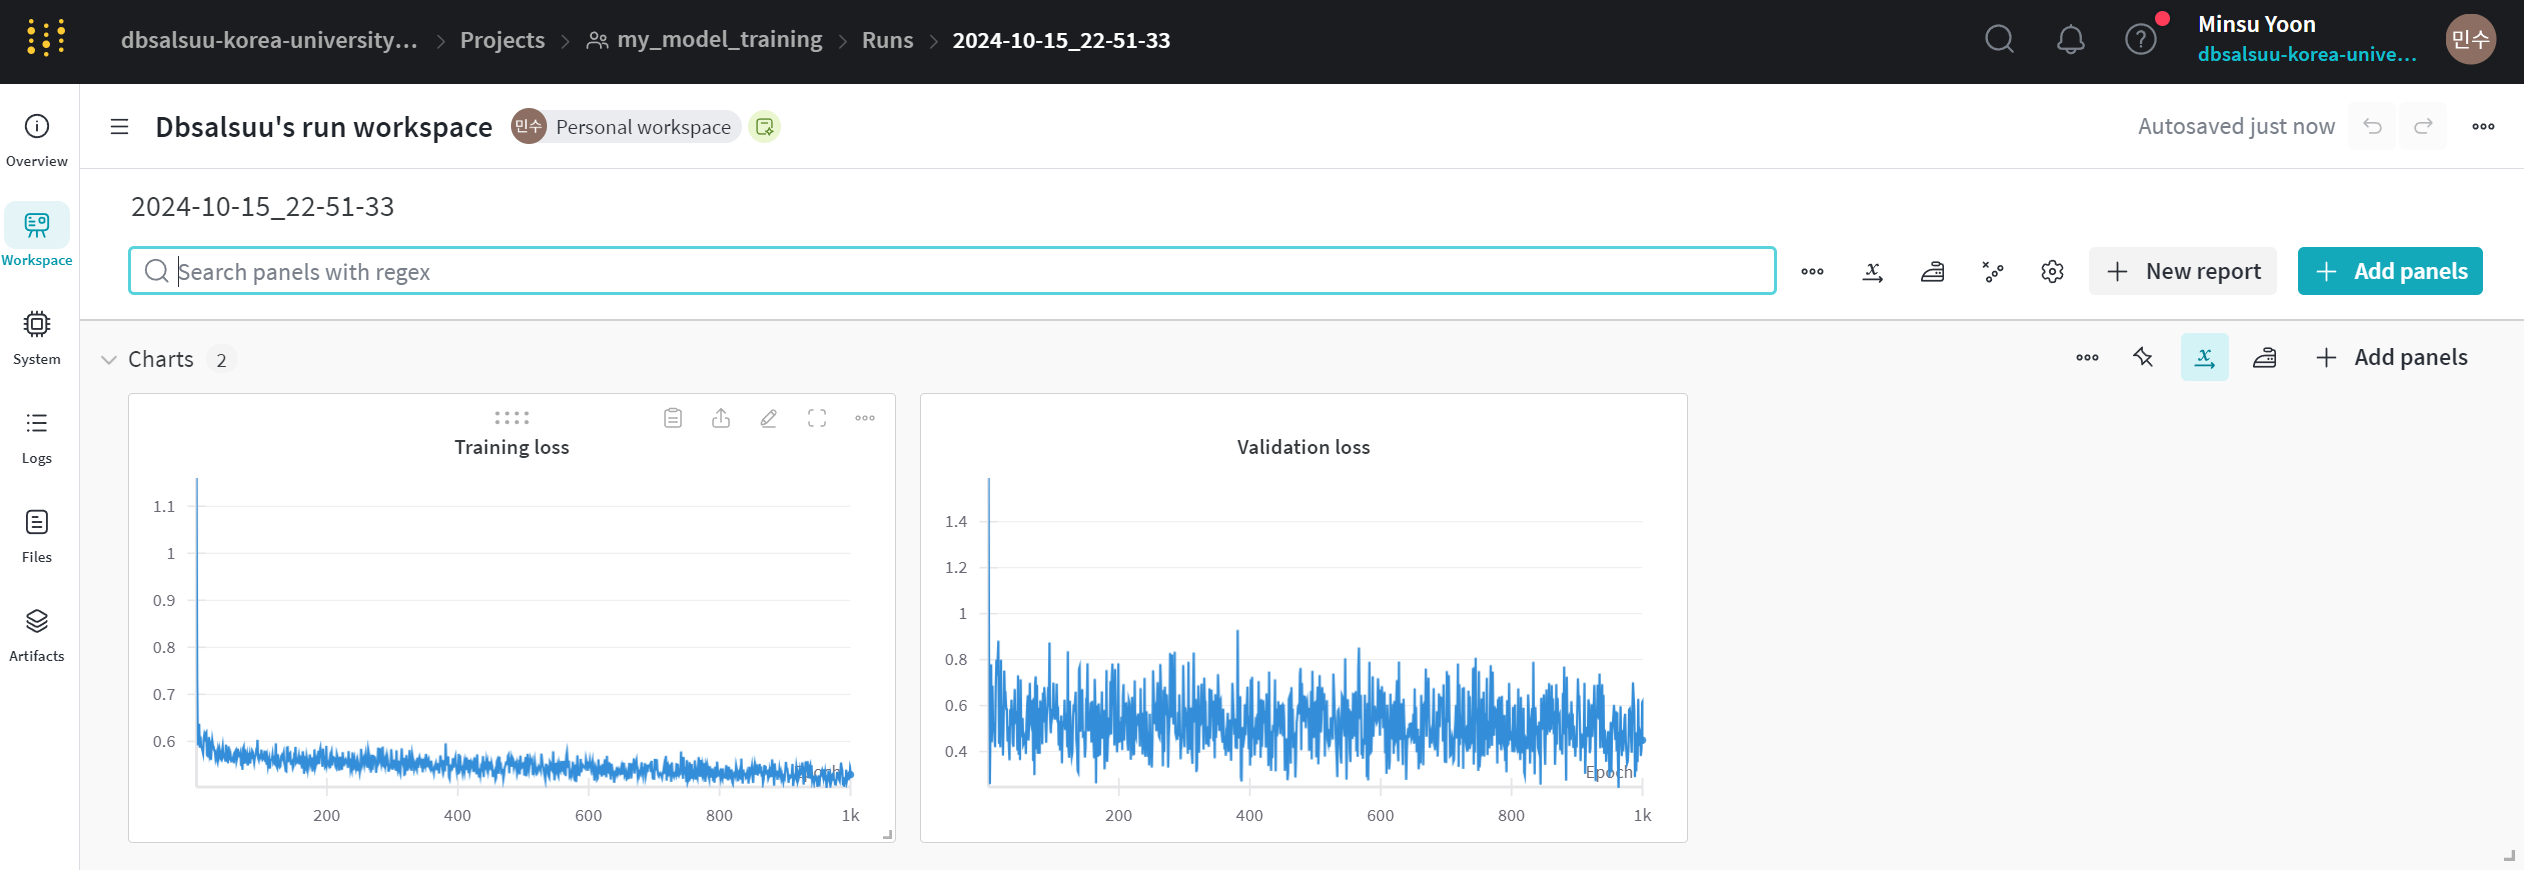

**· Activation Function은 다음과 같이 종류별로 별 차이가 없어서 PReLU로 정하였다.**

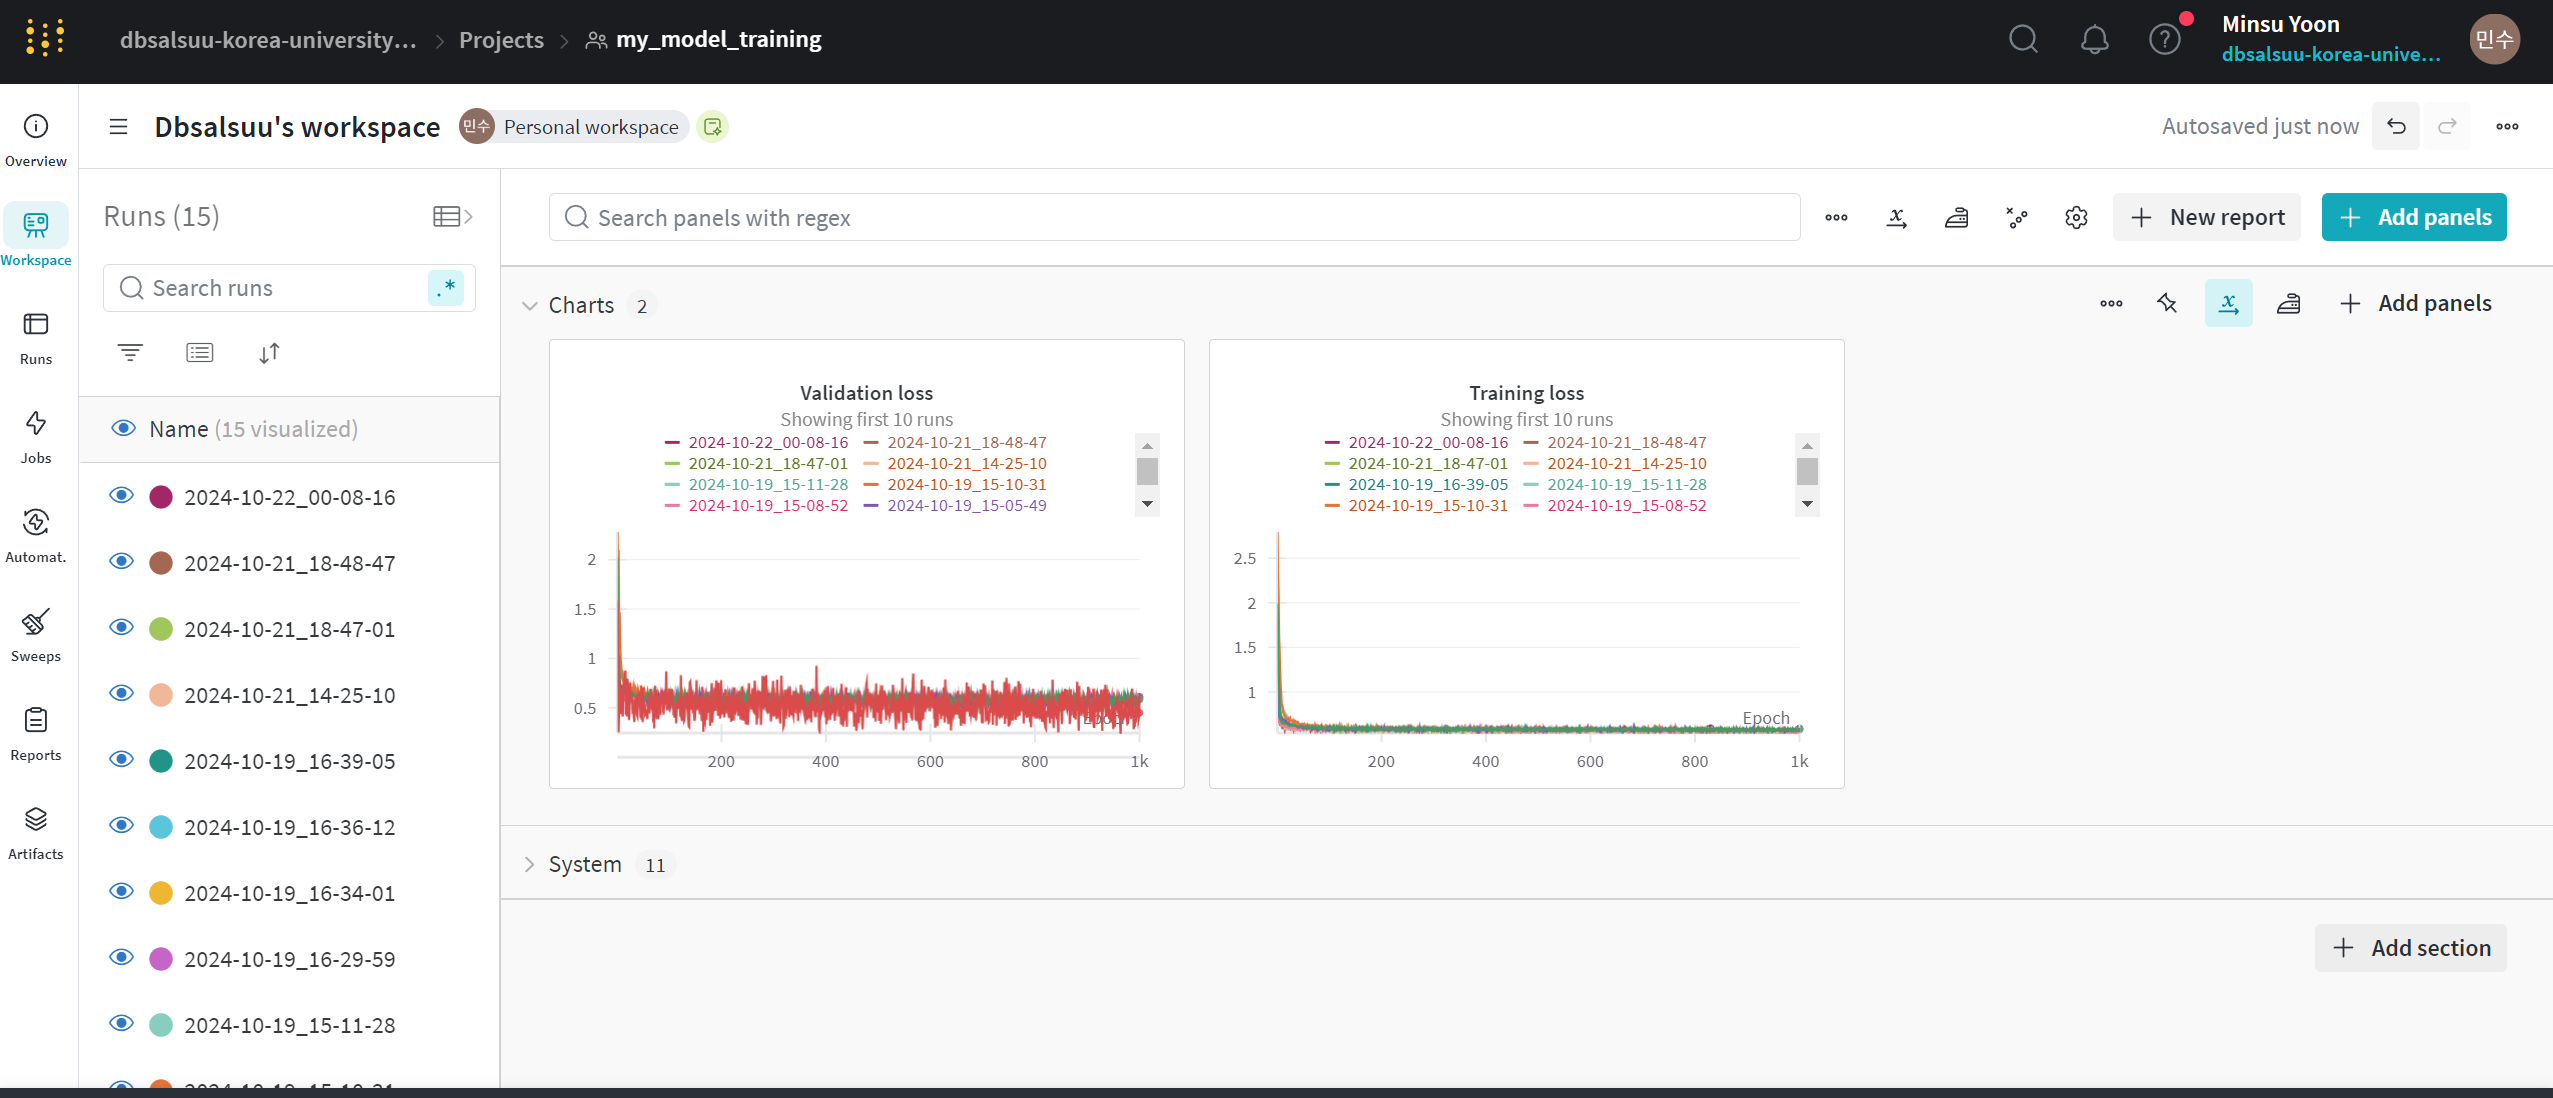

## **[요구사항 3] 테스트 및 submission.csv 생성**

**· 여러 테스트를 수행한 결과, validation_intervals = 10, early_stop_patience = 10 인 조건에서 학습한 모델의 성능이 가장 좋다고 판단하였고, 이 모델로 테스트하여 submission.csv를 생성하였다.**

**다음은 이에 대한 코드이다.(주피터 노트북에서 셀 실행할 때 인수를 넣는 방법을 알 수 없어서 아래 셀의 코드를 여기(주피터 노트북)에서 실행시키지는 못했음.)**

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import wandb
import argparse
import pandas as pd

from pathlib import Path
BASE_PATH = str(Path(__file__).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH, "!!!!!!!")

import sys
sys.path.append(BASE_PATH)

from _02_homeworks.homework_2 import titanic_dataset


def get_data():
    train_dataset, validation_dataset, test_dataset = titanic_dataset.get_preprocessed_dataset()
    print(len(train_dataset), len(validation_dataset), len(test_dataset))

    train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_data_loader, validation_data_loader, test_data_loader


class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.PReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.PReLU(),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
        )

    def forward(self, x):
        return self.model(x)


def get_model_and_optimizer():
    my_model = MyModel(n_input=11, n_output=2)  # n_input: 11 (피처 수), n_output: 2 (생존 여부 0/1)
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer


def do_validation(model, validation_data_loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
        for validation_batch in validation_data_loader:
            input = validation_batch['input']
            target = validation_batch['target']
            output_validation = model(input)
            loss = loss_fn(output_validation, target)
            loss_validation += loss.item()
            num_validations += 1

    validation_loss = loss_validation / num_validations
    return validation_loss


def do_test(model, test_data_loader):
    model.eval()
    predictions = []
    passenger_ids = []

    passenger_id_start = 892

    with torch.no_grad():
        for batch_index, test_batch in enumerate(test_data_loader):
            input_test = test_batch['input']
            output_test = model(input_test)
            predicted_test = torch.argmax(output_test, dim=-1).cpu().numpy()

            batch_size = len(predicted_test)
            passenger_ids.extend(range(passenger_id_start, passenger_id_start + batch_size))
            passenger_id_start += batch_size

            predictions.extend(predicted_test)

    return passenger_ids, predictions



def training_loop(model, optimizer, train_data_loader, validation_data_loader, test_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.CrossEntropyLoss()
    validation_intervals = 10  # 매 10 에포크마다 검증 수행
    early_stop_patience = 10  # 검증 손실이 나아지지 않는 에포크 허용 수
    patience_counter = 0
    best_validation_loss = float('inf')
    best_model_state = None  # 검증 손실이 가장 좋을 때의 모델 가중치 저장
    next_print_epoch = 100

    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train = 0.0
        num_trains = 0

        for train_batch in train_data_loader:
            input = train_batch['input']
            target = train_batch['target']
            output_train = model(input)
            loss = loss_fn(output_train, target)
            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증 손실 초기화
        validation_loss = None  

        # 매 10 에포크마다 검증 수행
        if epoch % validation_intervals == 0:
            validation_loss = do_validation(model, validation_data_loader)

            # 검증 손실이 감소하면 최적 모델로 기록하고 patience_counter 초기화
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                best_model_state = model.state_dict()  # 모델 가중치 저장
                patience_counter = 0  # patience counter 초기화
            else:
                # 검증 손실이 나아지지 않으면 patience counter 증가
                patience_counter += 1

        # wandb 로그 기록
        log_data = {
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
        }

        if validation_loss is not None:
            log_data["Validation loss"] = validation_loss

        wandb.log(log_data)

        # 에포크 출력 (100 에포크마다 출력)
        if epoch >= next_print_epoch:
            if validation_loss is not None:
                print(
                    f"Epoch {epoch}, "
                    f"Training loss {log_data['Training loss']:.4f}, "
                    f"Validation loss {validation_loss:.4f}"
                )
            else:
                print(
                    f"Epoch {epoch}, "
                    f"Training loss {log_data['Training loss']:.4f}"
                )
            next_print_epoch += 100

        # Early stopping 조건을 만족하면 종료
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}. Best validation loss: {best_validation_loss:.4f}")
            
            # 최적 모델의 가중치로 복원
            model.load_state_dict(best_model_state)

            # 최종 테스트 수행 및 CSV 저장
            passenger_ids, predictions = do_test(model, test_data_loader)
            submission_df = pd.DataFrame({
                'PassengerId': passenger_ids,
                'Survived': predictions
            })
            submission_df.to_csv(f'submission.csv', index=False)
            print(f"submission saved!")
            break
            

def main(args):
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [20, 20],
    }

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="my_model_training",
        notes="My first wandb experiment",
        tags=["my_model", "titanic"],
        name=current_time_str,
        config=config
    )

    # 데이터 로드
    train_data_loader, validation_data_loader, test_data_loader = get_data()

    # 모델 및 옵티마이저 설정
    linear_model, optimizer = get_model_and_optimizer()

    # 훈련 루프 실행
    training_loop(
        model=linear_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
        test_data_loader=test_data_loader
    )

    wandb.finish()


# https://docs.wandb.ai/guides/track/config
if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=1_000, help="Number of training epochs (int, default:1_000)"
    )

    args = parser.parse_args()

    main(args)

## **[요구사항 4] submission.csv 제출 및 등수 확인**

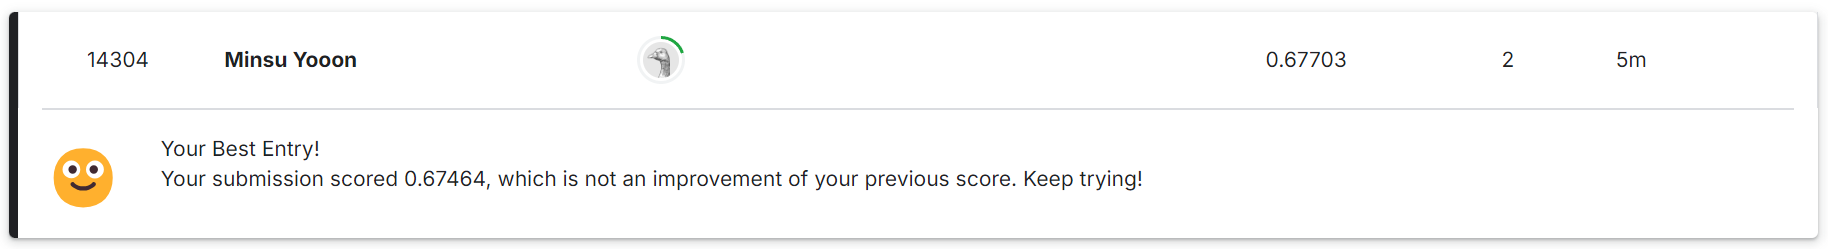

## **숙제 후기**

**· 모델을 설계하고, 그 모델을 직접 학습시키고, 그 모델로 결과물을 만들어내는 것까지의 과제 과정에서 딥러닝의 흐름을 느끼게 되는 값진 경험을 하게 되어 만족스러웠다.**